In [1]:
import logging
import os
import random
import sys
from collections import deque

sys.path.insert(0, './')

In [2]:
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import tensorflow.contrib.slim as slim
from nets.mobilenet import mobilenet_v2

BATCH_SIZE = 32
IMAGE_SIZE = 224

checkpoint_name = './mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt'

tf.__version__

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



'1.15.0'

In [3]:
def set_random_seed():
    seed = random.randrange(2 ** 32 - 2)
    logging.info('Using random seed {}'.format(seed))
    random.seed(seed)
    np.random.seed(seed + 1)
    tf.set_random_seed(seed + 2)
    
set_random_seed()

In [4]:
from dataset_factory import ImageCollector, ImgInverNormalize
import matplotlib.pyplot as plt

In [5]:
dataset = ImageCollector("./ARVision Data", 1, 100, 32) # Real data
dataset.StartLoadData()

module name: dataset_factory
parent process: 6811
process id: 7594


In [6]:
train_data = dataset.getLoadedData()

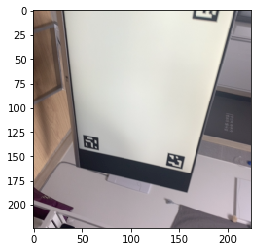

In [7]:
plt.imshow(ImgInverNormalize(train_data[1][0], 1.))
plt.show()

In [8]:
input_img = tf.placeholder(tf.float32, [None] + [IMAGE_SIZE, IMAGE_SIZE, 3])
input_label = tf.placeholder(tf.float32, [None] + [6])

In [9]:
with tf.contrib.slim.arg_scope(mobilenet_v2.training_scope(is_training=False)):
    logits, endpoints = mobilenet_v2.mobilenet(input_img, num_classes=6)

Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


In [10]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
reuse_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="MobilenetV2")
reuse_var_refine = [var for var in reuse_vars if '6DOF' not in var.name]

saver = tf.train.Saver(var_list=reuse_var_refine)
new_saver = tf.train.Saver()

In [11]:
with sess.as_default():
    train_data = dataset.getLoadedData()
    saver.restore(sess, checkpoint_name)
    x = endpoints['6DOF'].eval(feed_dict={input_img: train_data[1]})

INFO:tensorflow:Restoring parameters from ./mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt


INFO:tensorflow:Restoring parameters from ./mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt


In [12]:
x[0]

array([-0.3199135 , -0.04276671, -0.07564701,  0.06544954,  0.07939928,
       -0.0139066 ], dtype=float32)

# Save Trained Model

In [13]:
save_dir = './checkpoints'
save_path = os.path.join(save_dir, 'model.ckpt')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
save_path = new_saver.save(sess, save_path)
tf.train.write_graph(sess.graph, './', 'model.pbtxt')

'./model.pbtxt'

# Tensorflow to CoreML

In [14]:
from tensorflow.python.tools.freeze_graph import freeze_graph
import tfcoreml

In [15]:
# Provide these to run freeze_graph:
# Graph definition file, stored as protobuf TEXT
graph_def_file = './model.pbtxt'
# Trained model's checkpoint name
checkpoint_file = './checkpoints/model.ckpt'
# Frozen model's output name
frozen_model_file = './frozen_model.pb'
# Output nodes. If there're multiple output ops, use comma separated string, e.g. "out1,out2".
output_node_names = 'MobilenetV2/Logits/6DOF' 


# Call freeze graph
freeaed = freeze_graph(input_graph=graph_def_file,
                       input_saver="",
                       input_binary=False,
                       input_checkpoint=checkpoint_file,
                       output_node_names=output_node_names,
                       restore_op_name="save/restore_all",
                       filename_tensor_name="save/Const:0",
                       output_graph=frozen_model_file,
                       clear_devices=True,
                       initializer_nodes="")

Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt


INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt


Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


INFO:tensorflow:Froze 262 variables.


INFO:tensorflow:Froze 262 variables.


INFO:tensorflow:Converted 262 variables to const ops.


INFO:tensorflow:Converted 262 variables to const ops.


In [19]:
"""
Step 2: Call converter
"""

# Provide these inputs in addition to inputs in Step 1
# A dictionary of input tensors' name and shape (with batch)
input_tensor_shapes = {"Placeholder":[1,224,224,3]} # batch size is 1
# Output CoreML model path
coreml_model_file = './model.mlmodel'
output_tensor_names = ['MobilenetV2/Logits/6DOF']


# Call the converter
coreml_model = tfcoreml.convert(
    tf_model_path=frozen_model_file, 
    mlmodel_path=coreml_model_file, 
    input_name_shape_dict=input_tensor_shapes,
    output_feature_names=output_tensor_names,
    minimum_ios_deployment_target='13')

0 assert nodes deleted
262 nodes deleted
156 nodes deleted
0 nodes deleted
[Op Fusion] fuse_bias_add() deleted 2 nodes.
2 identity nodes deleted
36 disconnected nodes deleted
[Op Fusion] Fused 312 nodes into BatchNorms.
[SSAConverter] Converting function main ...
[SSAConverter] [1/172] Converting op type: 'Placeholder', name: 'Placeholder', output_shape: (1, 224, 224, 3).
[SSAConverter] [2/172] Converting op type: 'Const', name: 'MobilenetV2/expanded_conv/depthwise/depthwise_weights/read', output_shape: (3, 3, 32, 1).
[SSAConverter] [3/172] Converting op type: 'Const', name: 'MobilenetV2/expanded_conv_1/depthwise/depthwise_weights/read', output_shape: (3, 3, 96, 1).
[SSAConverter] [4/172] Converting op type: 'Const', name: 'MobilenetV2/expanded_conv_2/depthwise/depthwise_weights/read', output_shape: (3, 3, 144, 1).
[SSAConverter] [5/172] Converting op type: 'Const', name: 'MobilenetV2/expanded_conv_3/depthwise/depthwise_weights/read', output_shape: (3, 3, 144, 1).
[SSAConverter] [6/172

[SSAConverter] [130/172] Converting op type: 'BatchNorm', name: 'MobilenetV2/expanded_conv_12/project/BatchNorm/FusedBatchNormV3/Add_batch_norm', output_shape: (1, 96, 14, 14).
[SSAConverter] [131/172] Converting op type: 'AddV2', name: 'MobilenetV2/expanded_conv_12/add', output_shape: (1, 96, 14, 14).
[SSAConverter] [132/172] Converting op type: 'Conv2D', name: 'MobilenetV2/expanded_conv_13/expand/Conv2D', output_shape: (1, 576, 14, 14).
[SSAConverter] [133/172] Converting op type: 'BatchNorm', name: 'MobilenetV2/expanded_conv_13/expand/BatchNorm/FusedBatchNormV3/Add_batch_norm', output_shape: (1, 576, 14, 14).
[SSAConverter] [134/172] Converting op type: 'Relu6', name: 'MobilenetV2/expanded_conv_13/expand/Relu6', output_shape: (1, 576, 14, 14).
[SSAConverter] [135/172] Converting op type: 'DepthwiseConv2dNative', name: 'MobilenetV2/expanded_conv_13/depthwise/depthwise', output_shape: (1, 576, 7, 7).
[SSAConverter] [136/172] Converting op type: 'BatchNorm', name: 'MobilenetV2/expanded

In [38]:
# Test CoreML convert result
coreml_test_data = train_data[1][0][np.newaxis,:]
coreml_inputs = {'Placeholder': coreml_test_data} # (sequence_length=1,batch=1,channels=784)
coreml_output = coreml_model.predict(coreml_inputs, useCPUOnly=True)
coreml_output

{'MobilenetV2/Logits/6DOF': array([[-0.31988192, -0.04275768, -0.07563604,  0.0654453 ,  0.0794016 ,
         -0.01390594]], dtype=float32)}